<a href="https://colab.research.google.com/github/maryamxasghari/Computer_Vision/blob/main/Training_yolov5_Custom_dataset_Scoreboard_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
  <img width="130" height="80" src="https://upload.wikimedia.org/wikipedia/commons/3/31/Boston_University_wordmark.svg">
</p>

<h5 align="center">CS673 Software Engineering Term Project</h5>
<h6 align="center">Fall 2021</h6>

<h1 align="center">GameOver</h1>
<h2 align="center">Sport scoring notification system</h2>

### This Notebook is to show you how to train YOLOv5 for detection using  our labeled data

## Requierments 

download and save following files in your local drive from [YOLOv5](https://drive.google.com/drive/folders/1EhP4ykGtdngrI7dxF5vBMFlFA4lhsd6j?usp=sharing) folder in drive. 

**Note** For easy access you can create yolov5 folder in your drive and save everything there

#### Config files
* custom_yolov5s.yaml
* data.yaml

#### Weights
* best.pt 
* best2.pt 

#### A few images to test 
* image422.jpg 
* image73.jpg
* image347.jpg 



### Mount your drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

### Clone the YOLOv5 repository Install Dependencies



In [ ]:
# clone YOLOv5 repository

!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 9481, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9481 (delta 0), reused 0 (delta 0), pack-reused 9473
Receiving objects: 100% (9481/9481), 9.90 MiB | 30.53 MiB/s, done.
Resolving deltas: 100% (6588/6588), done.
/content/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 636 kB 9.7 MB/s 
Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


### If you check all the files are here and ready to use

In [ ]:
%ls

data/       hubconf.py  README.md*         train.py        weights/
detect.py   LICENSE     requirements.txt*  tutorial.ipynb
Dockerfile  models/     test.py            utils/


## Import labeled images Using roboflow 

In [ ]:
!curl -L "https://app.roboflow.com/ds/w1IvNccZr4?key=ekHVT1JksP" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   888  100   888    0     0   1055      0 --:--:-- --:--:-- --:--:--  1054
100 14.3M  100 14.3M    0     0  10.5M      0  0:00:01  0:00:01 --:--:--  311M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/image1015_jpg.rf.abd65cf5687c1ee34408290d7d8fdd1a.jpg  
 extracting: test/images/image1120_jpg.rf.49ee6b6f1ad318fbff40a7330cec3d77.jpg  
 extracting: test/images/image1472_jpg.rf.3f25b7ec0ce663dc5361b6337a630dbb.jpg  
 extracting: test/images/image1485_jpg.rf.172dc611bd32ebce0872e35bebde0320.jpg  
 extracting: test/images/image1591_jpg.rf.625915d20046b81ae1ab3ae403a57ef2.jpg  
 extracting: test/images/image1786_jpg.rf.4f2c42c690dd70294552d0a3d5648bed.jpg  
 extracting: tes

In [ ]:
%ls

data/       hubconf.py          README.md*           test.py         utils/
data.yaml   LICENSE             README.roboflow.txt  train/          valid/
detect.py   models/             requirements.txt*    train.py        weights/
Dockerfile  README.dataset.txt  test/                tutorial.ipynb


## copy the files from your drive to cloud

In [ ]:
!cp /mydrive/yolov5/custom_yolov5s.yaml ./
!cp /mydrive/yolov5/data.yaml ./ 

In [ ]:
%cat custom_yolov5s.yaml

# parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3

In [ ]:
%cat ./data.yaml

train: ./train/images
val: ./valid/images

nc: 1
names: ['score']


In [ ]:
!cp /mydrive/yolov5/best.pt ./
!cp /mydrive/yolov5/best2.pt ./ 

In [ ]:
%ls

best2.pt             detect.py   README.dataset.txt   test.py         valid/
best.pt              Dockerfile  README.md*           train/          weights/
custom_yolov5s.yaml  hubconf.py  README.roboflow.txt  train.py
data/                LICENSE     requirements.txt*    tutorial.ipynb
data.yaml            models/     test/                utils/


## Start training 

* img 416  --> input size for your model
* batch 16 --> batch size
* epochs 1000 --> number of epochs
* data './data.yaml' --> path to data.yaml
* cfg ./custom_yolov5s.yaml --> path to config file
* weights './best.pt' --> path to weight
* name ./yolov5_3 --> folder name to save the results

In [ ]:
# train yolov5s on for 3000 epochs

%%time
!python train.py --img 416 --batch 16 --epochs 3000 --data './data.yaml' --cfg ./custom_yolov5s.yaml --weights './runs/train/yolov5_3/weights/best.pt'  --name ./yolov5_4  --cache

Streaming output truncated to the last 5000 lines.
     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
 2001/2999     1.39G  0.006902  0.001132         0  0.008034         8       416: 100% 8/8 [00:01<00:00,  7.89it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 2/2 [00:00<00:00, 14.96it/s]
                 all          33          26           1       0.962       0.965       0.643

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
 2002/2999     1.39G  0.008371  0.001542         0  0.009913         5       416: 100% 8/8 [00:01<00:00,  7.97it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 2/2 [00:00<00:00, 12.62it/s]
                 all          33          26           1       0.962       0.965       0.646

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
 2003/2999     1.39G  0.006795

In [ ]:
##

## Results 
 Here we can see that mAP.5 is really high which means almost all the detection has 50% overlap with GT  but mAP 0.5-0.95 is around  60% which means our model is still detection a part of logos. Based on these we may be better to stich to out best.pt  from before. Or we can label 1000s of images and train again. 

### check the saved results

In [ ]:
!ls ./runs/train/yolov5_4

confusion_matrix.png				   results.png
events.out.tfevents.1633472106.5c7b225c11c1.746.0  results.txt
F1_curve.png					   test_batch0_labels.jpg
hyp.yaml					   test_batch0_pred.jpg
labels_correlogram.jpg				   test_batch1_labels.jpg
labels.jpg					   test_batch1_pred.jpg
opt.yaml					   train_batch0.jpg
P_curve.png					   train_batch1.jpg
PR_curve.png					   train_batch2.jpg
R_curve.png					   weights


### Copy the results to your local drive

In [ ]:
%cp -r ./runs/train/yolov5_4 /mydrive/yolov5

### Display some of the plots 

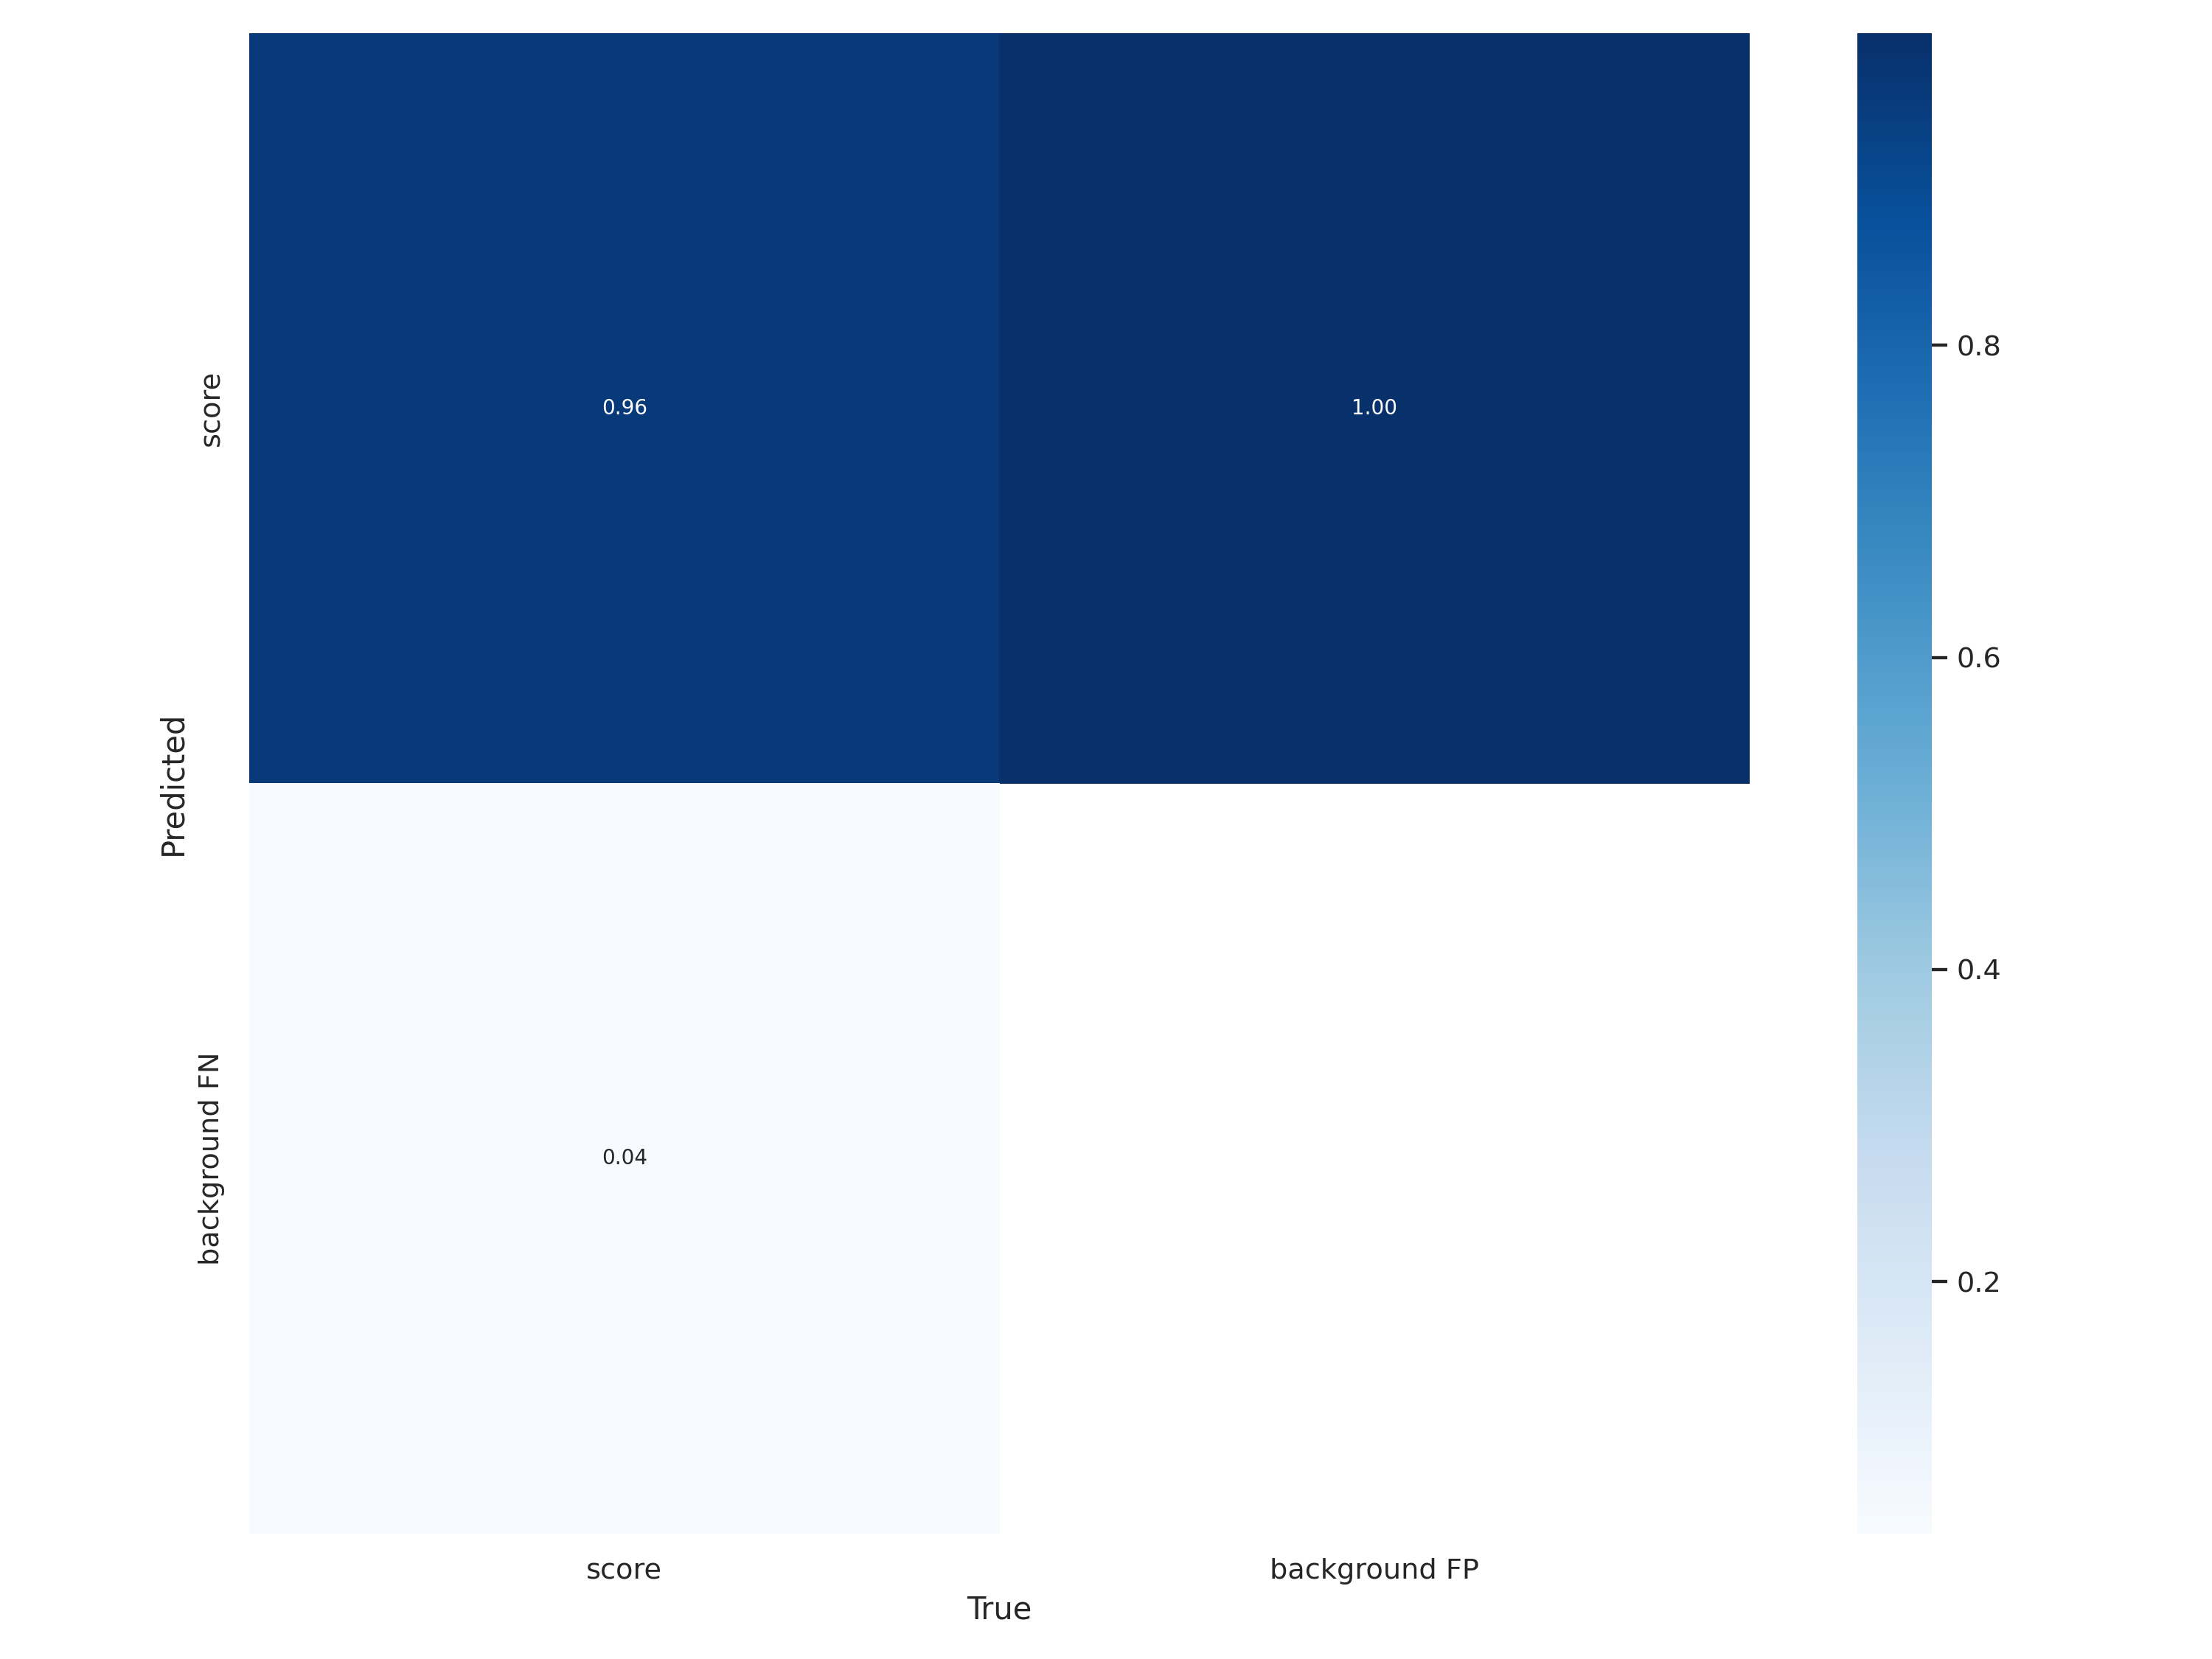

In [ ]:
Image(filename='./runs/train/yolov5_4/confusion_matrix.png', width=500)

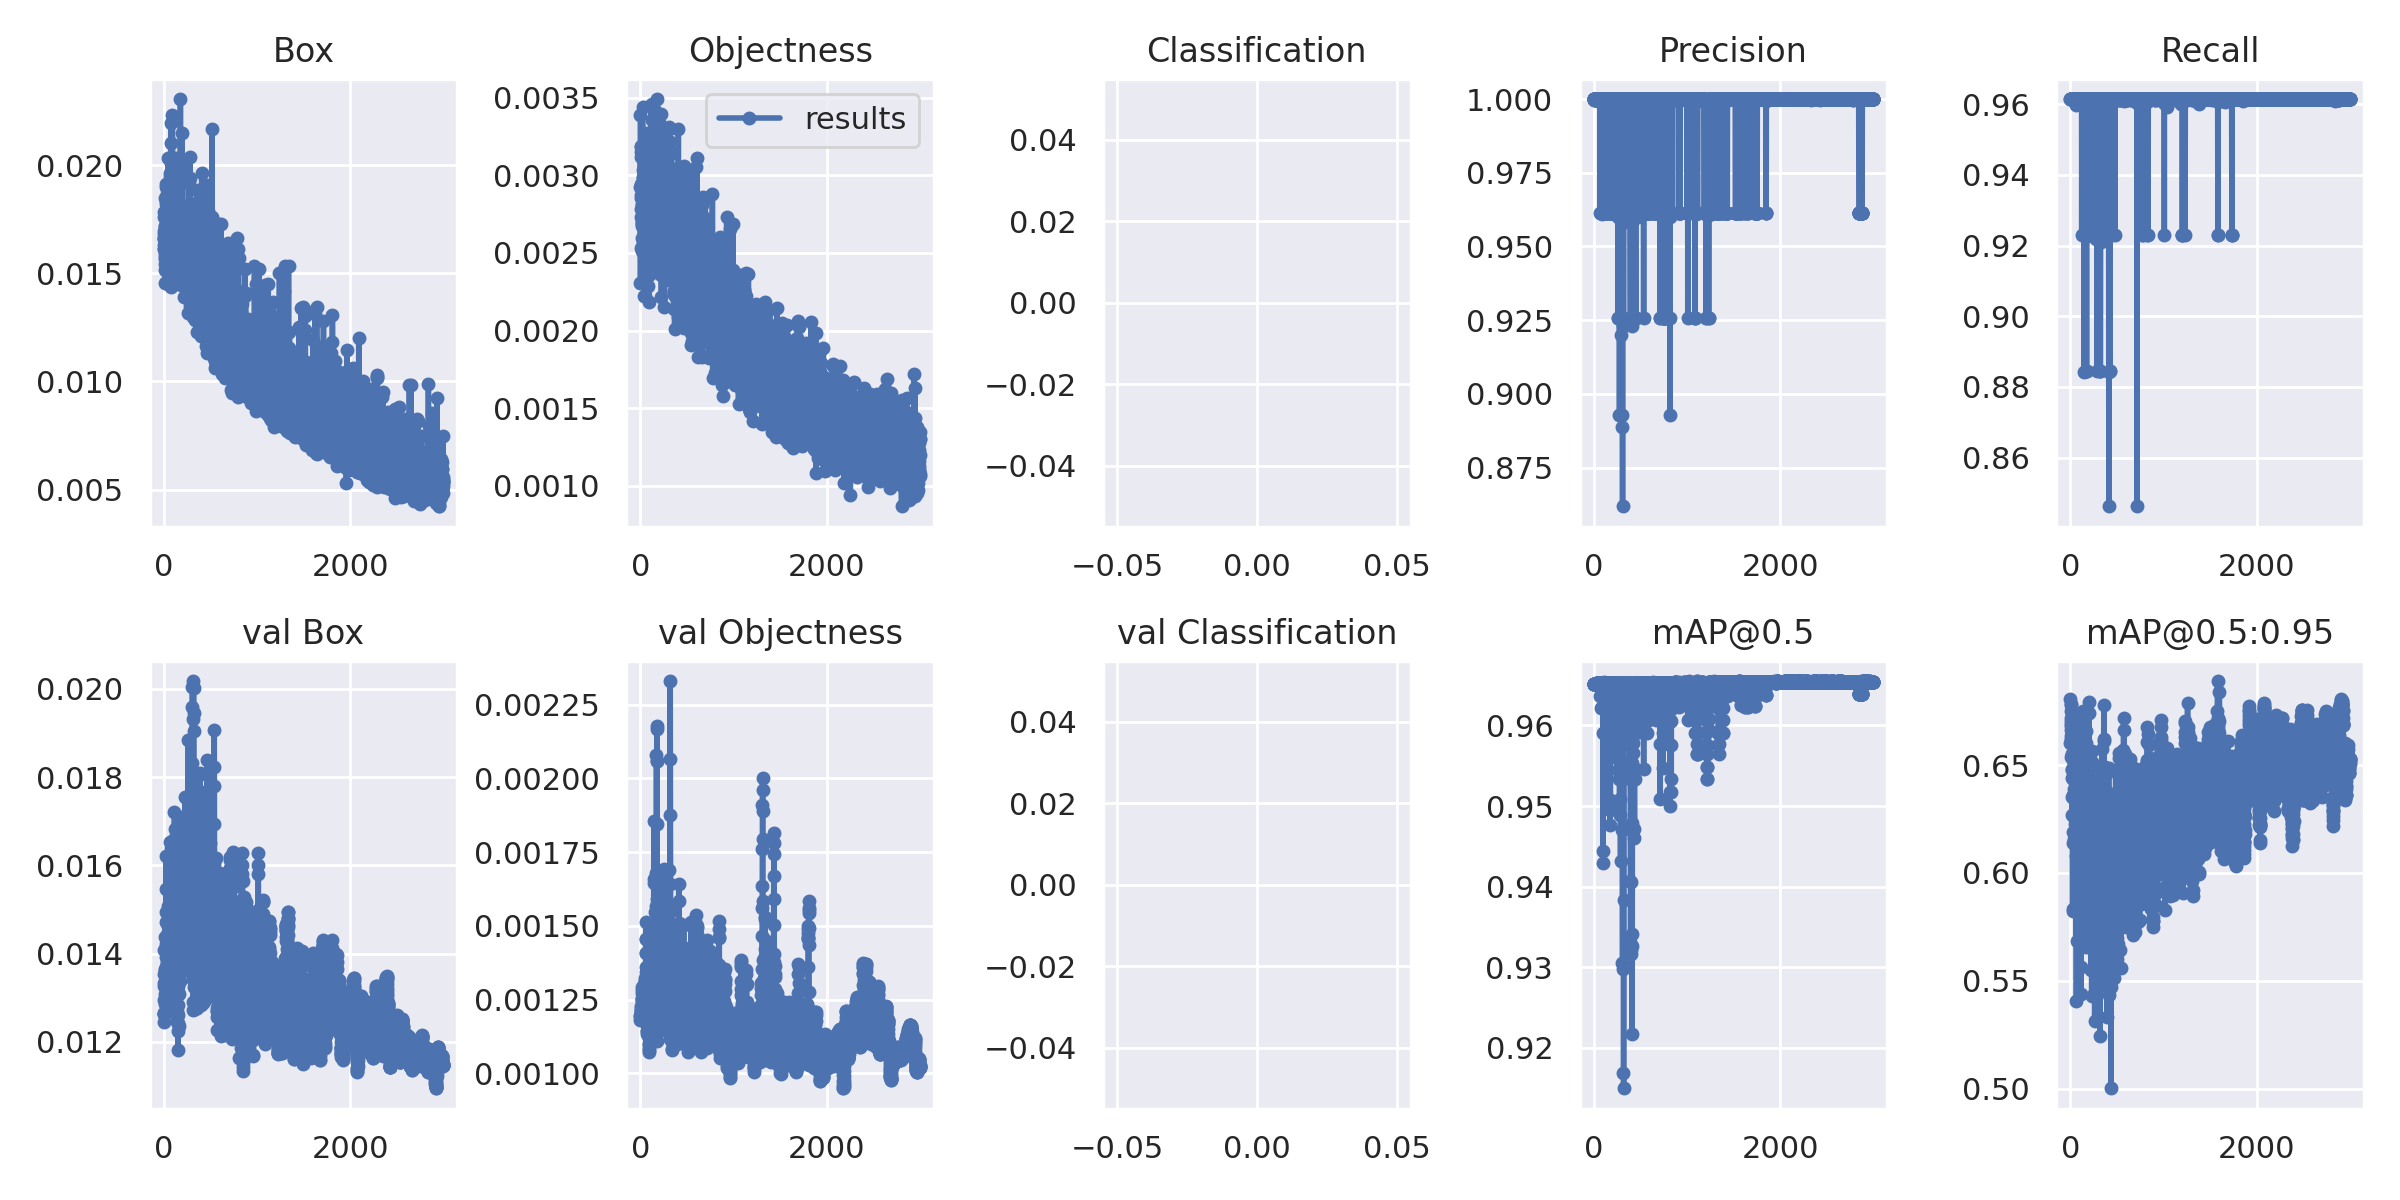

In [ ]:
Image(filename='./runs/train/yolov5_4/results.png', width=500)

### Check out the sample of Augmented data that the model used 

GROUND TRUTH AUGMENTED TRAINING DATA:


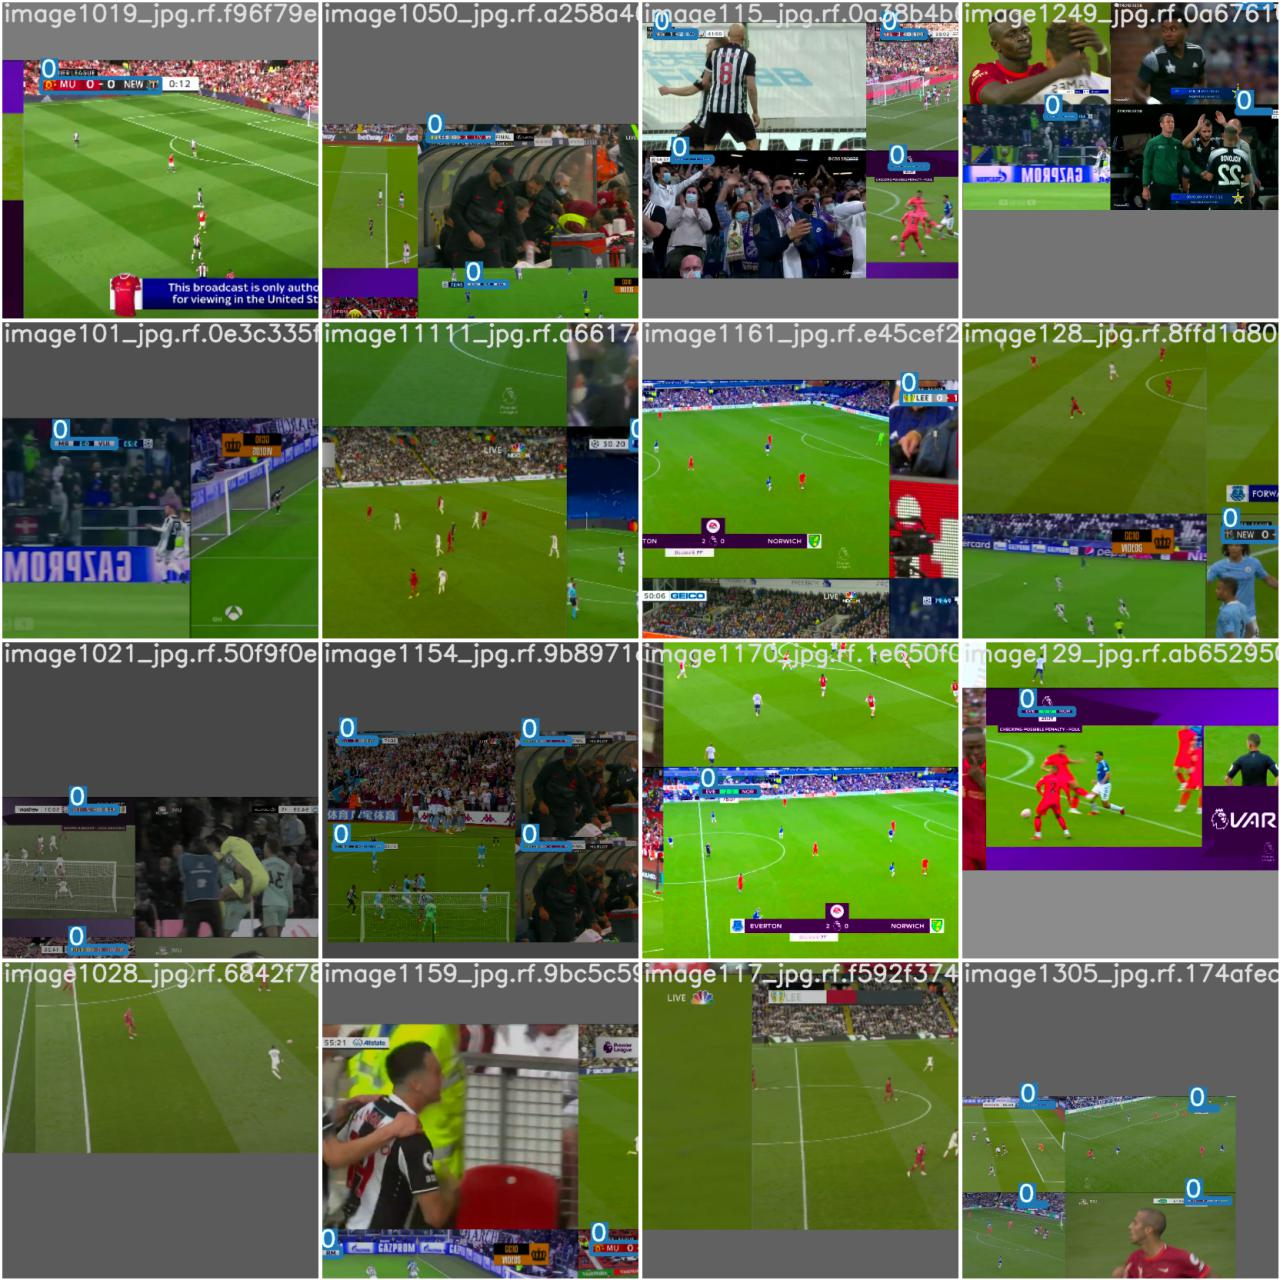

In [ ]:
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='./runs/train/yolov5_4/train_batch0.jpg', width=500)

## Use the new weight to detect the box on the test data 

In [ ]:
!python detect.py --weights ./runs/train/yolov5_4/weights/best.pt --img 416 --conf 0.4 --source ./test/images --save-txt --name 'results3'


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='results3', project='runs/detect', save_conf=False, save_txt=True, source='./test/images', update=False, view_img=False, weights=['./runs/train/yolov5_4/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS
image 1/17 /content/yolov5/test/images/image1015_jpg.rf.abd65cf5687c1ee34408290d7d8fdd1a.jpg: 256x416 1 score,

### Display the results

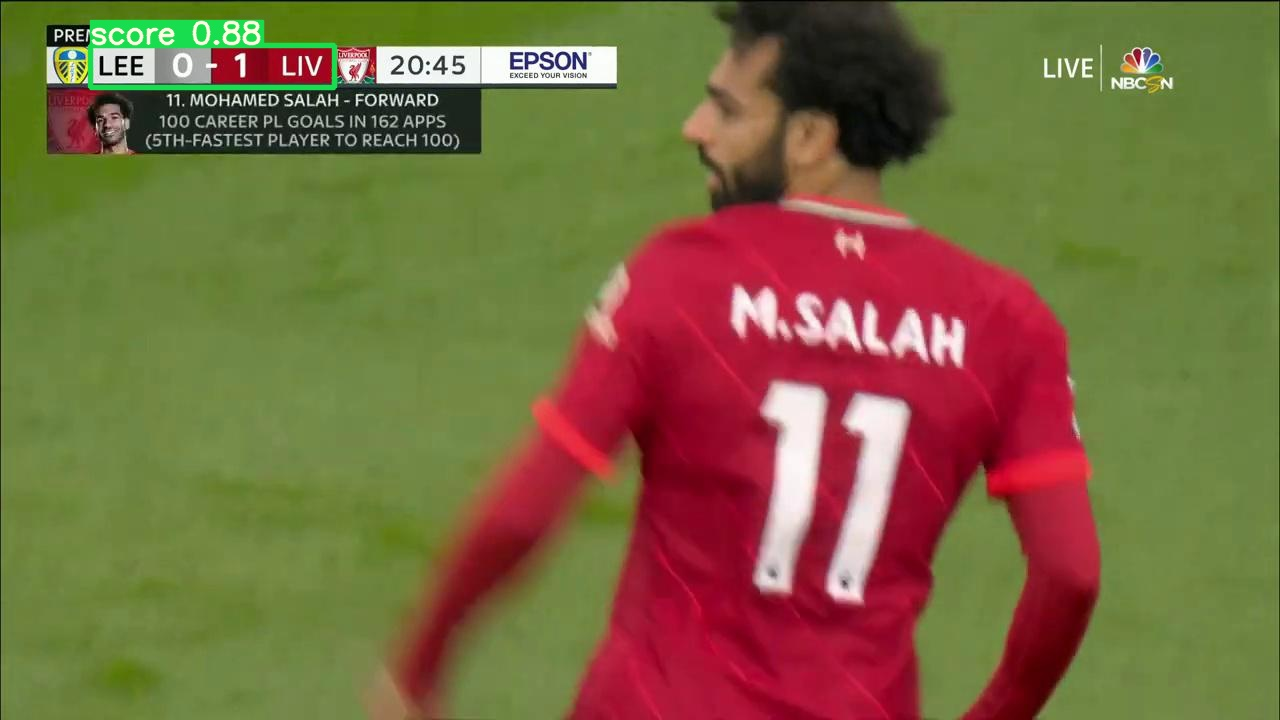

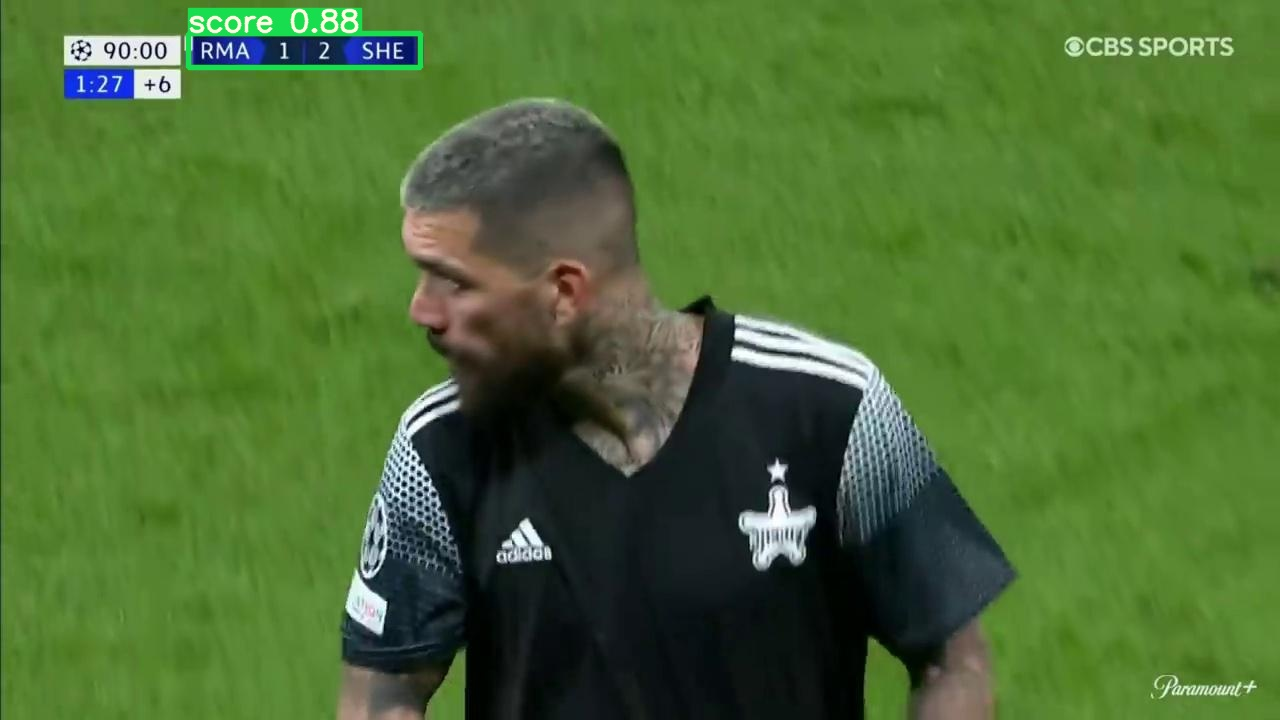

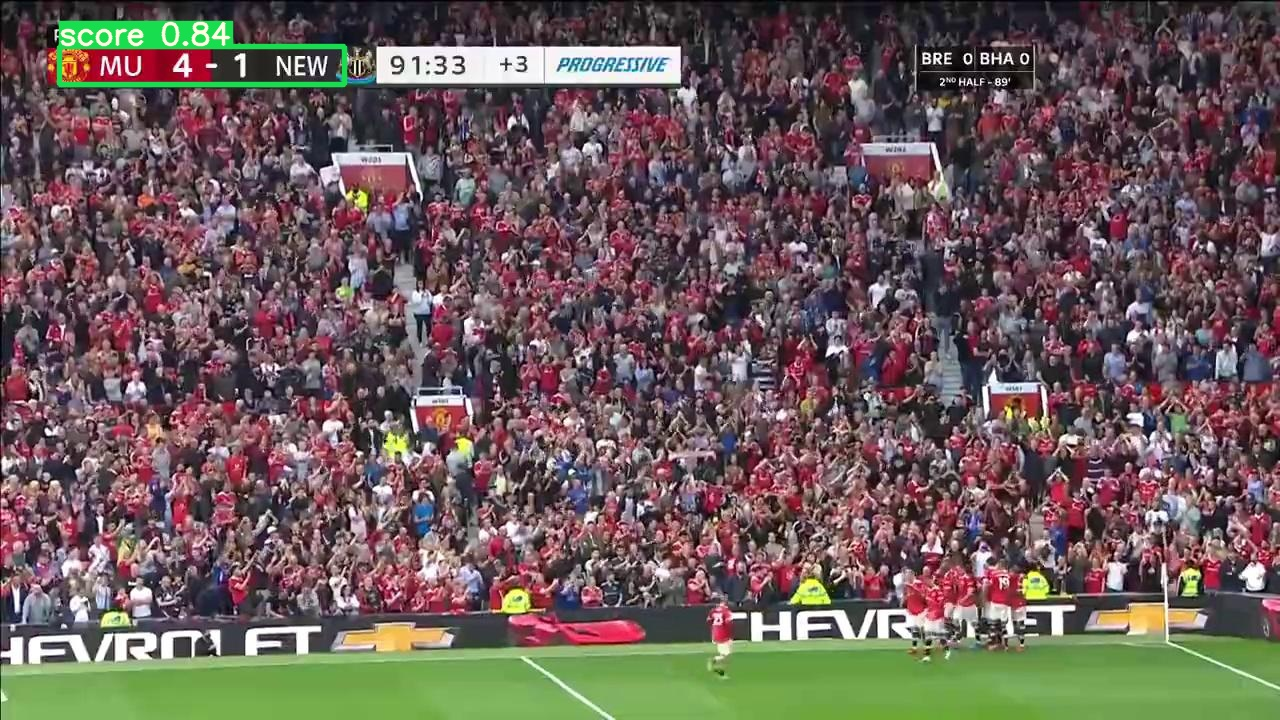

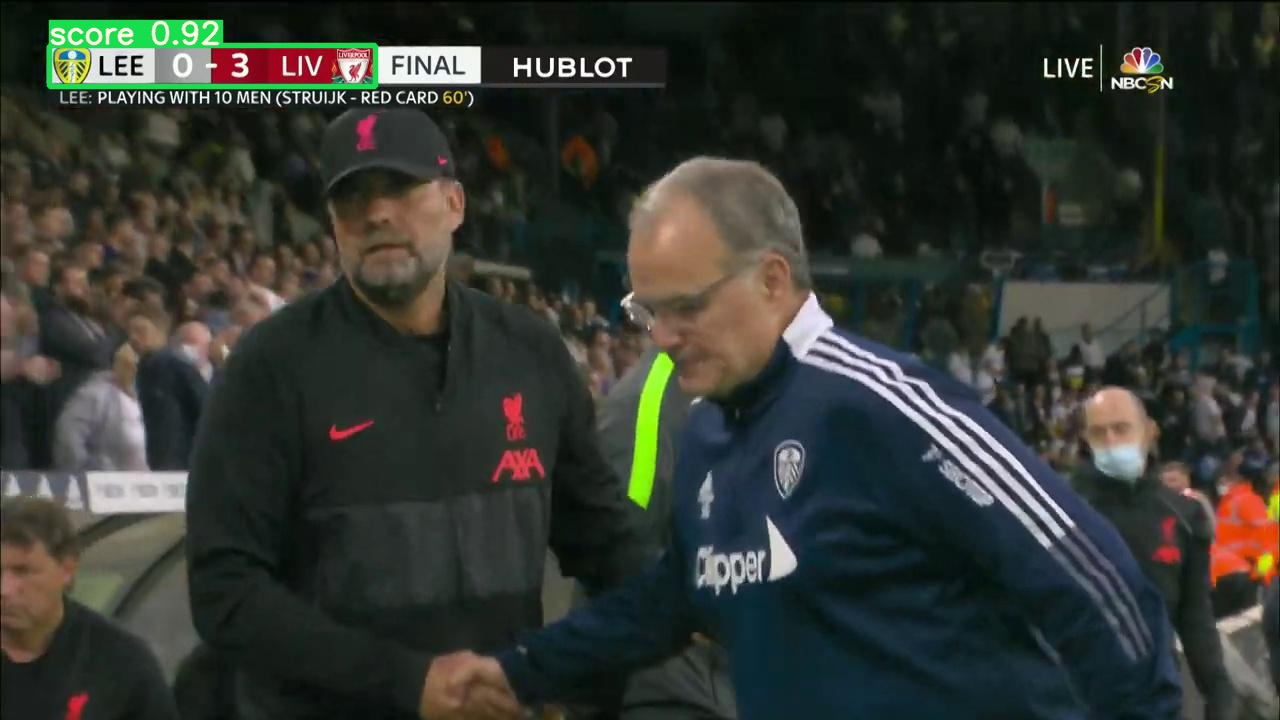

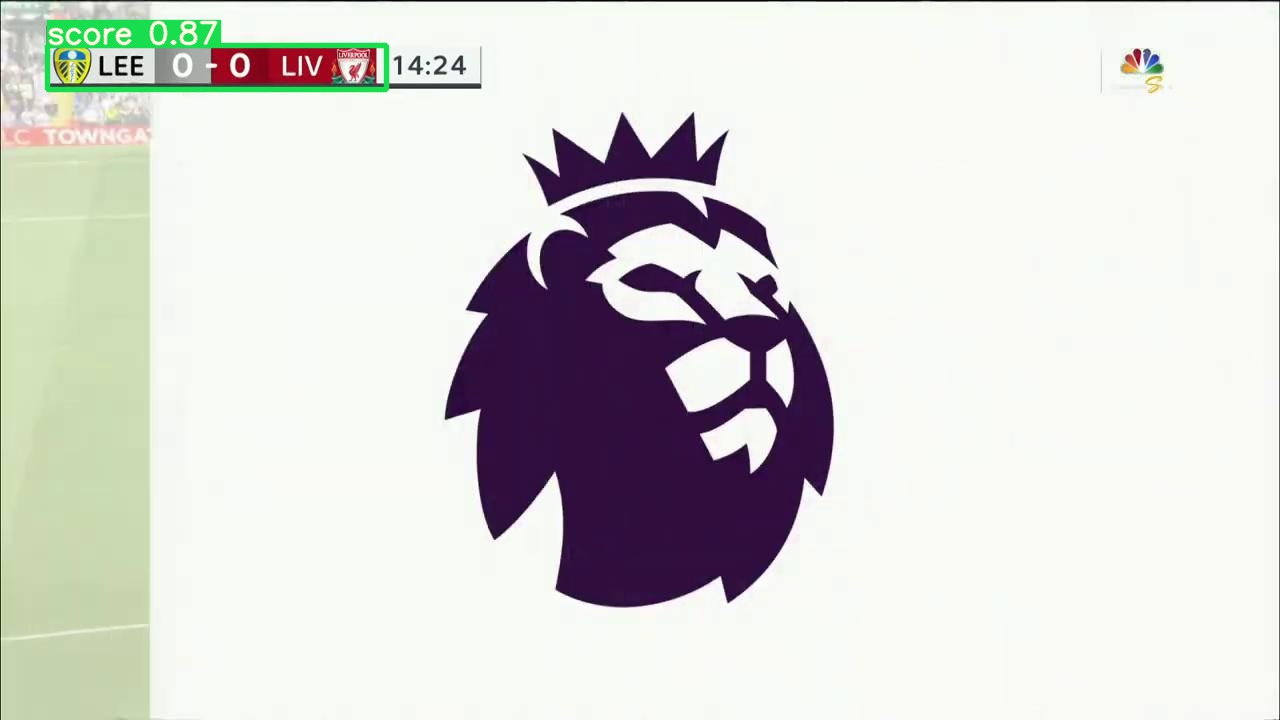

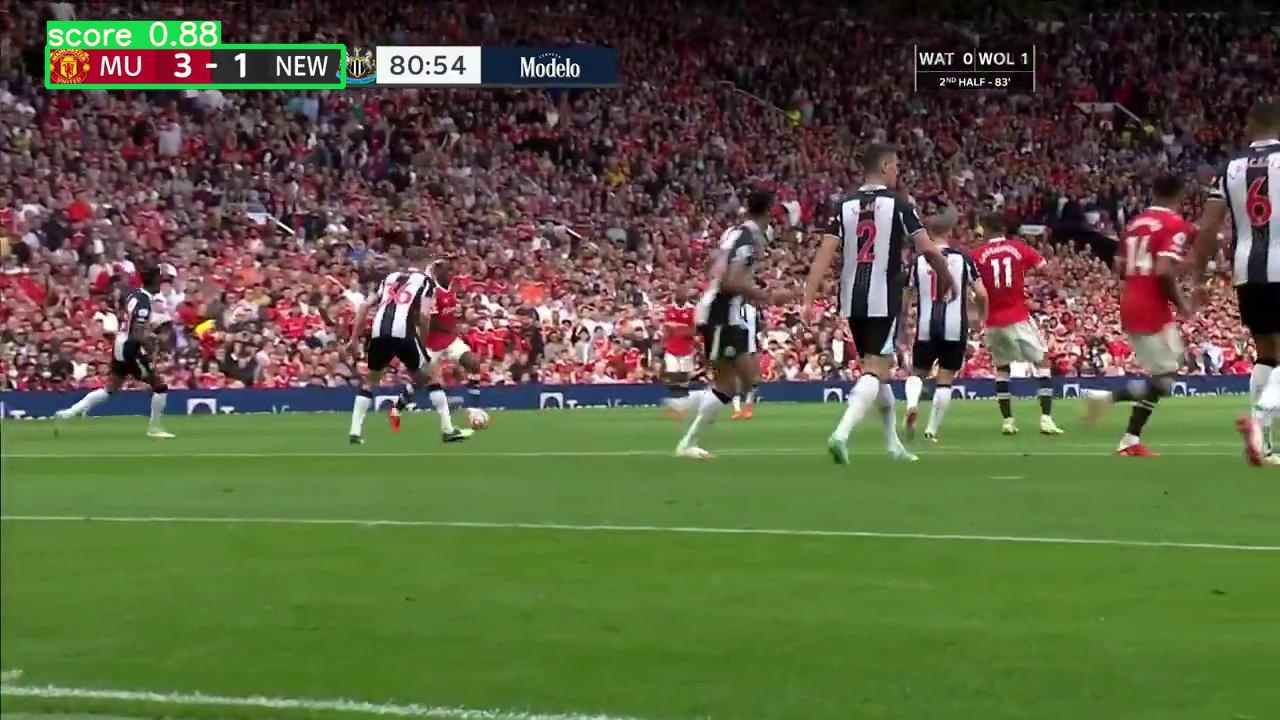

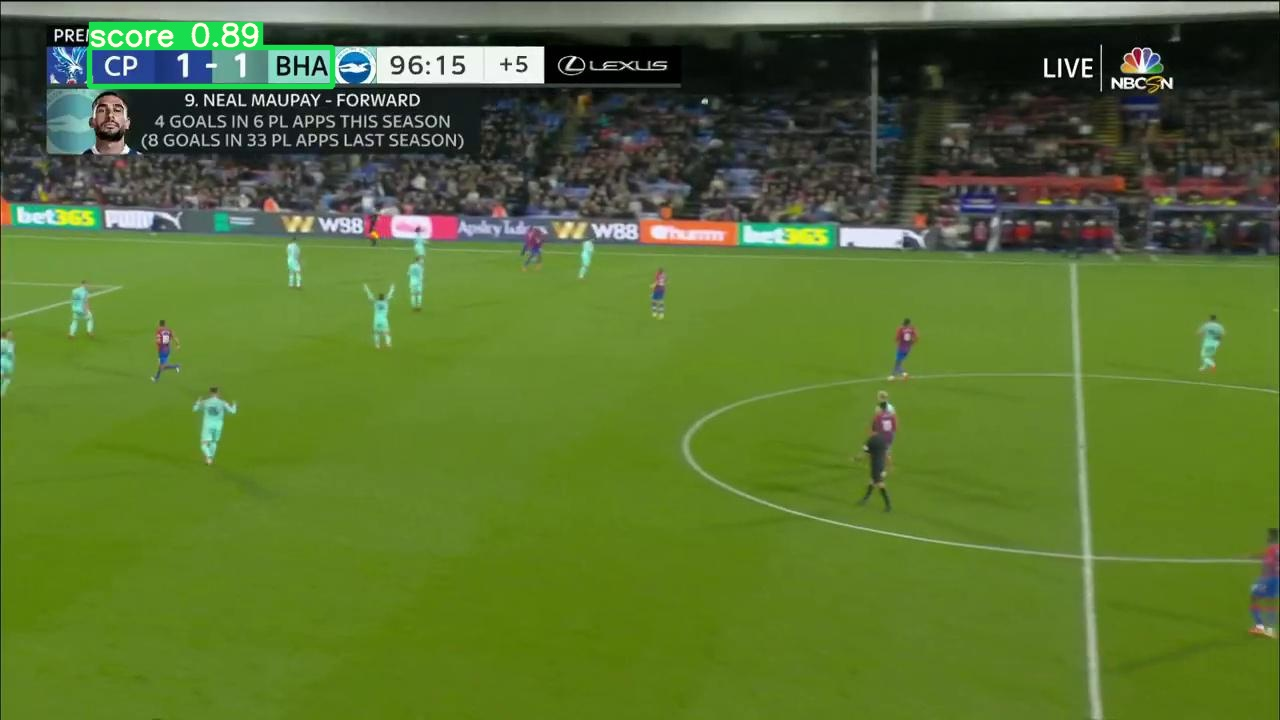

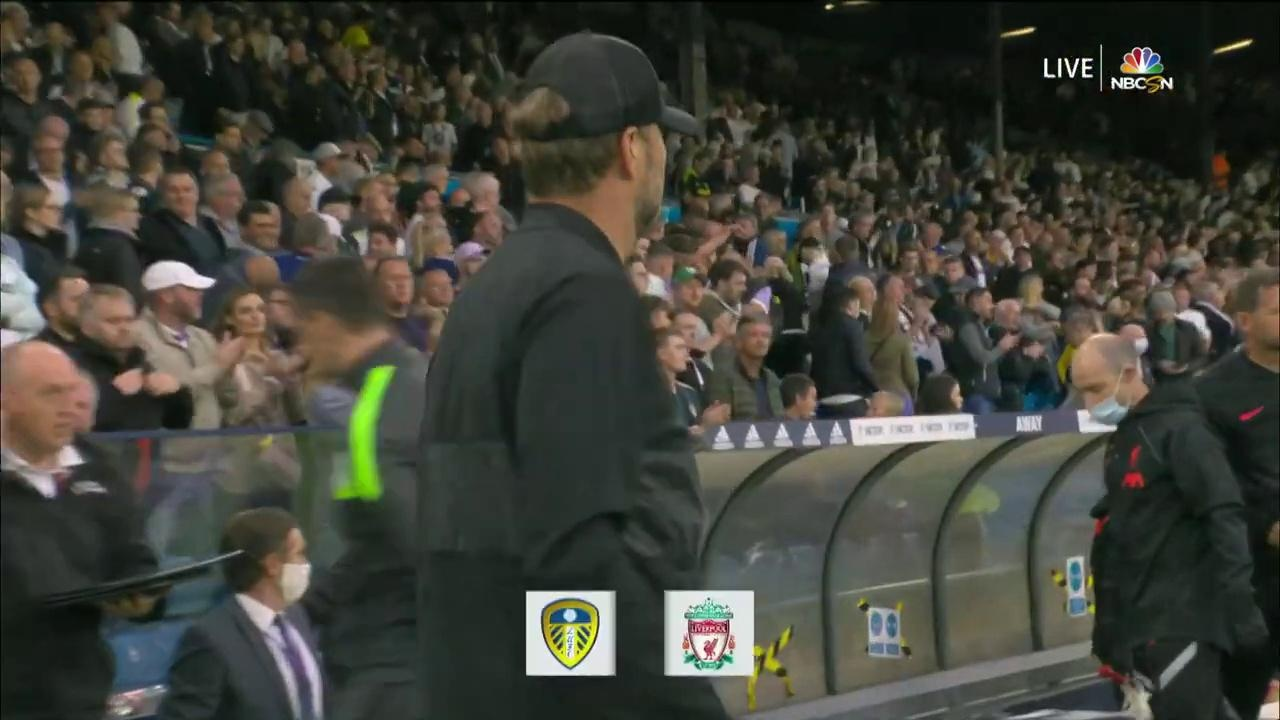

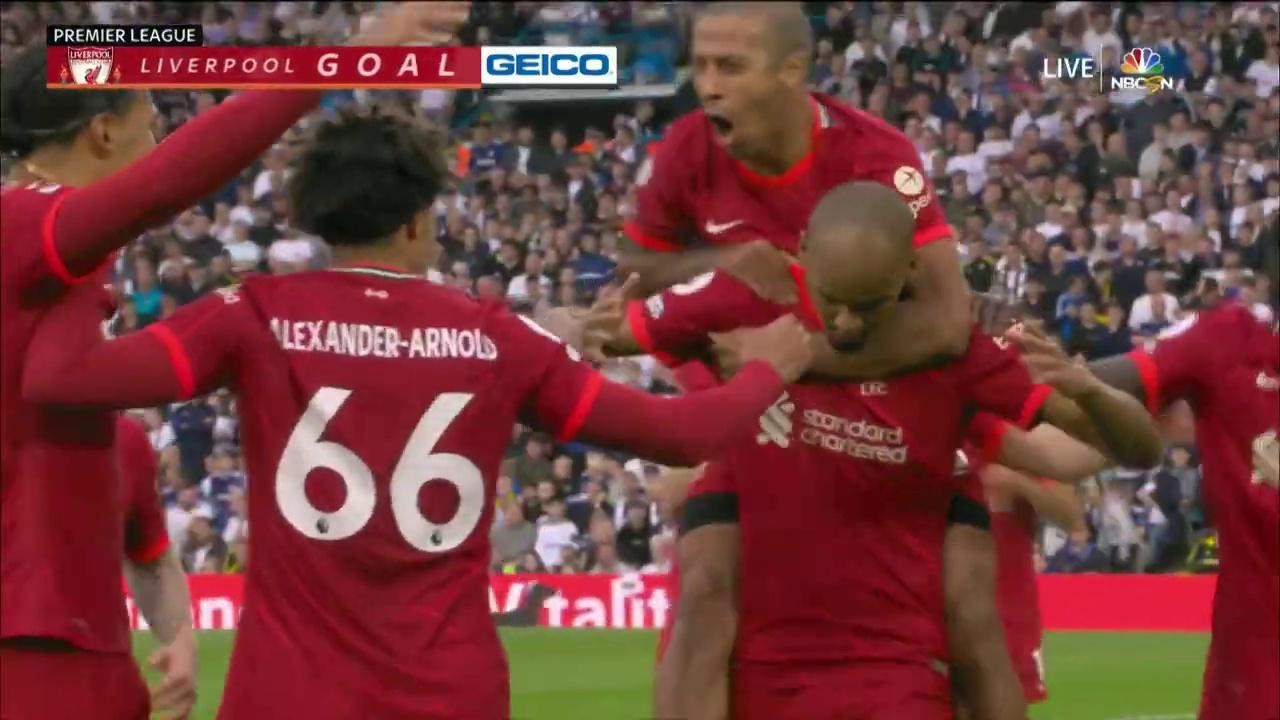

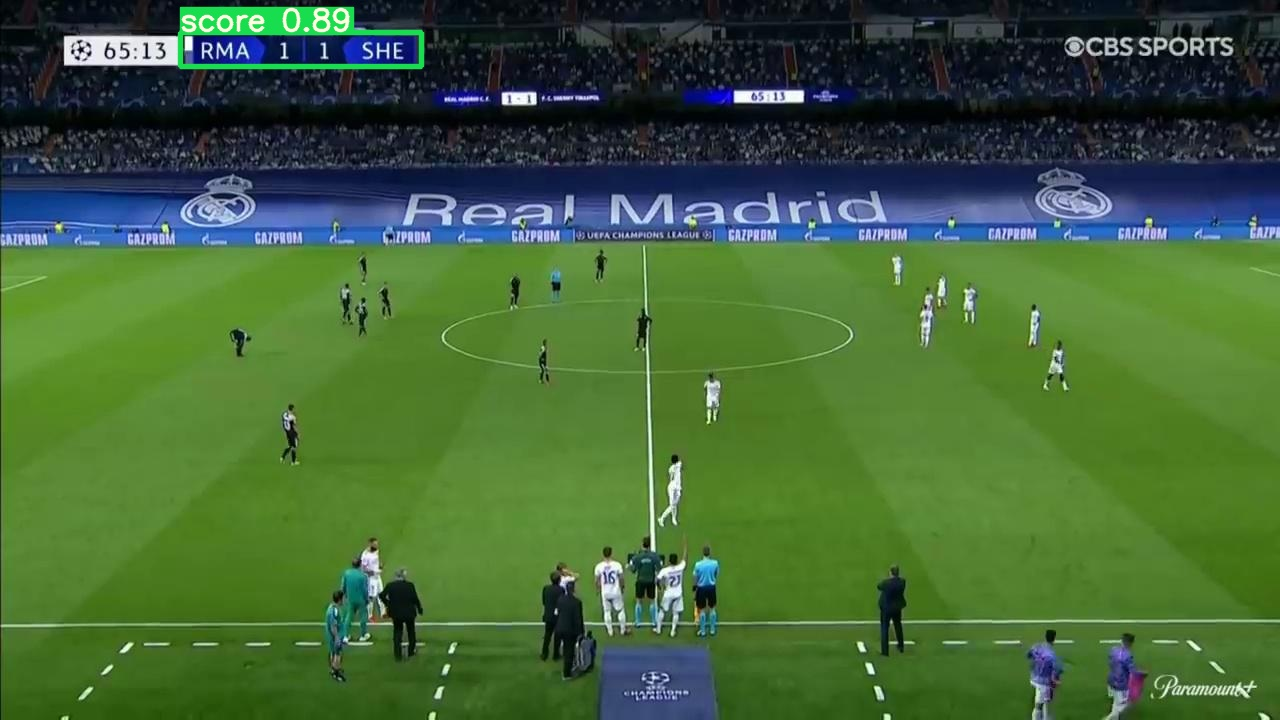

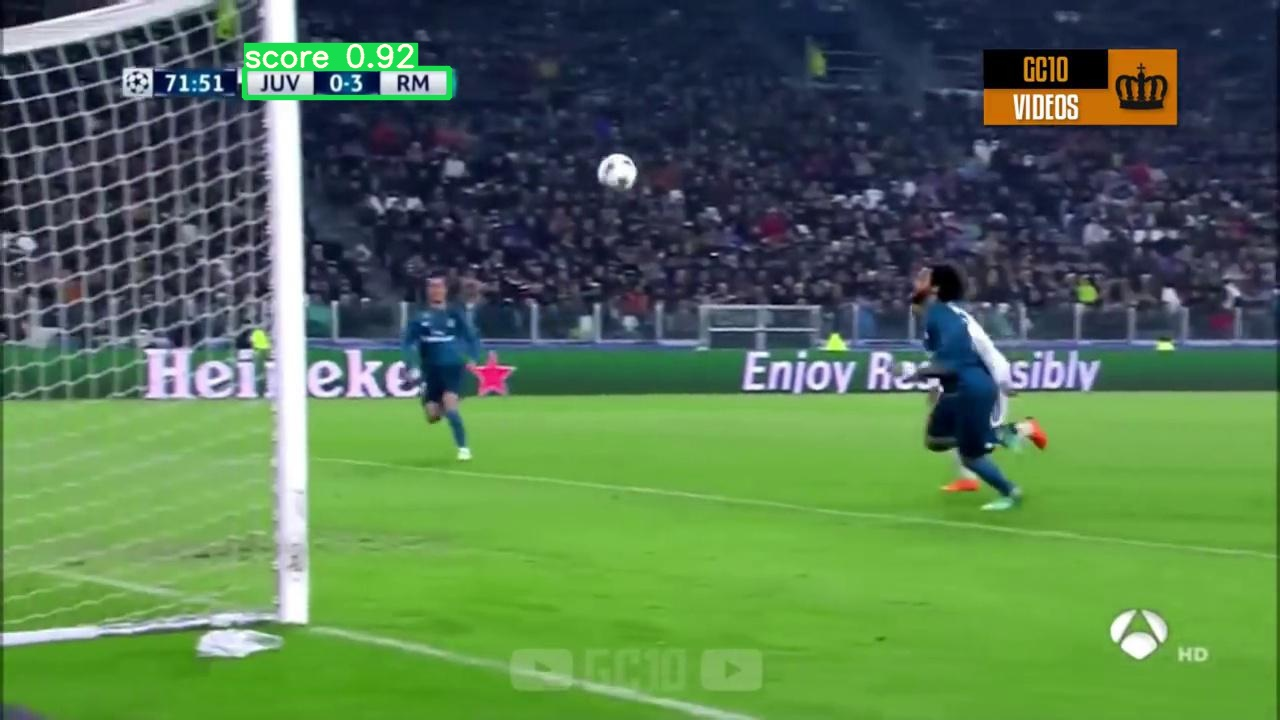

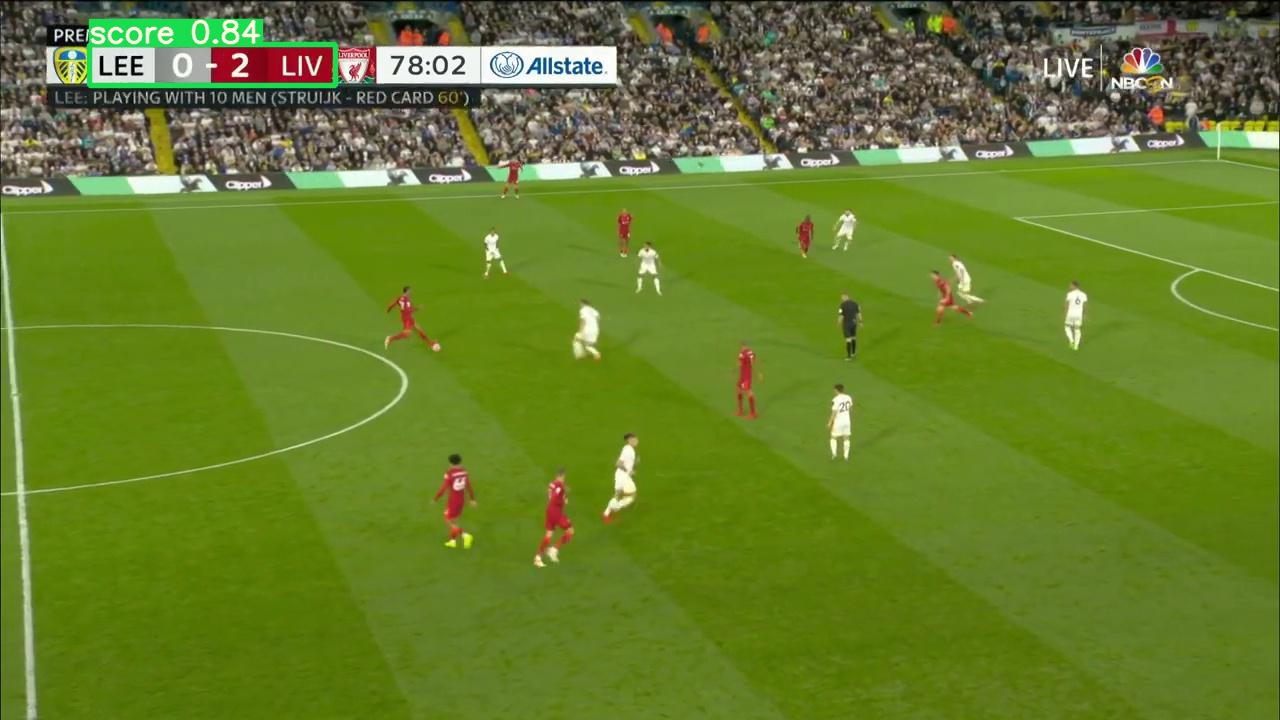

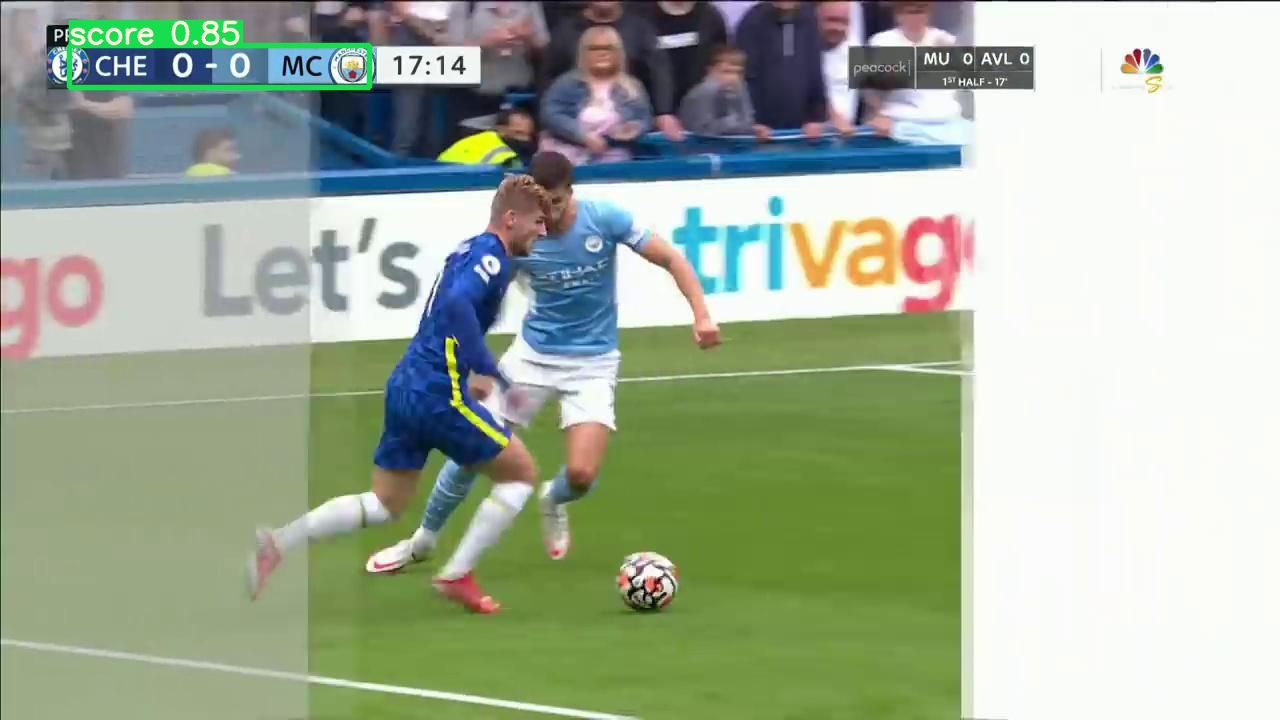

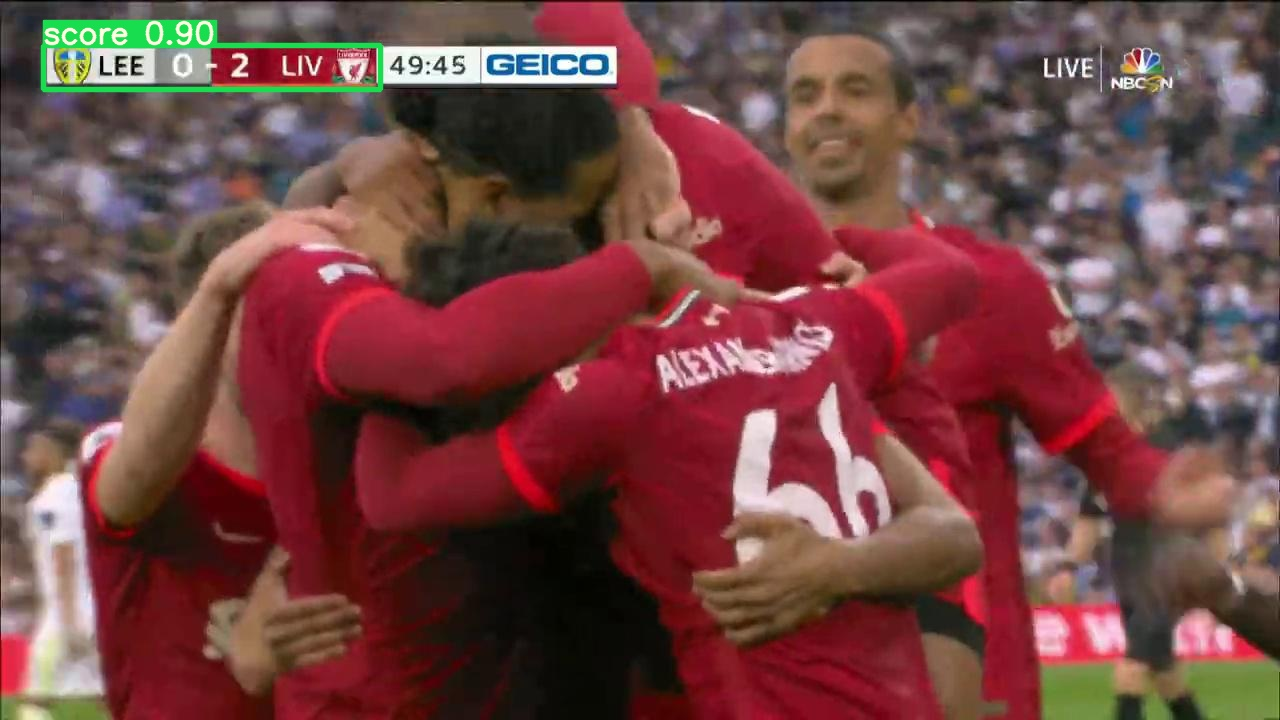

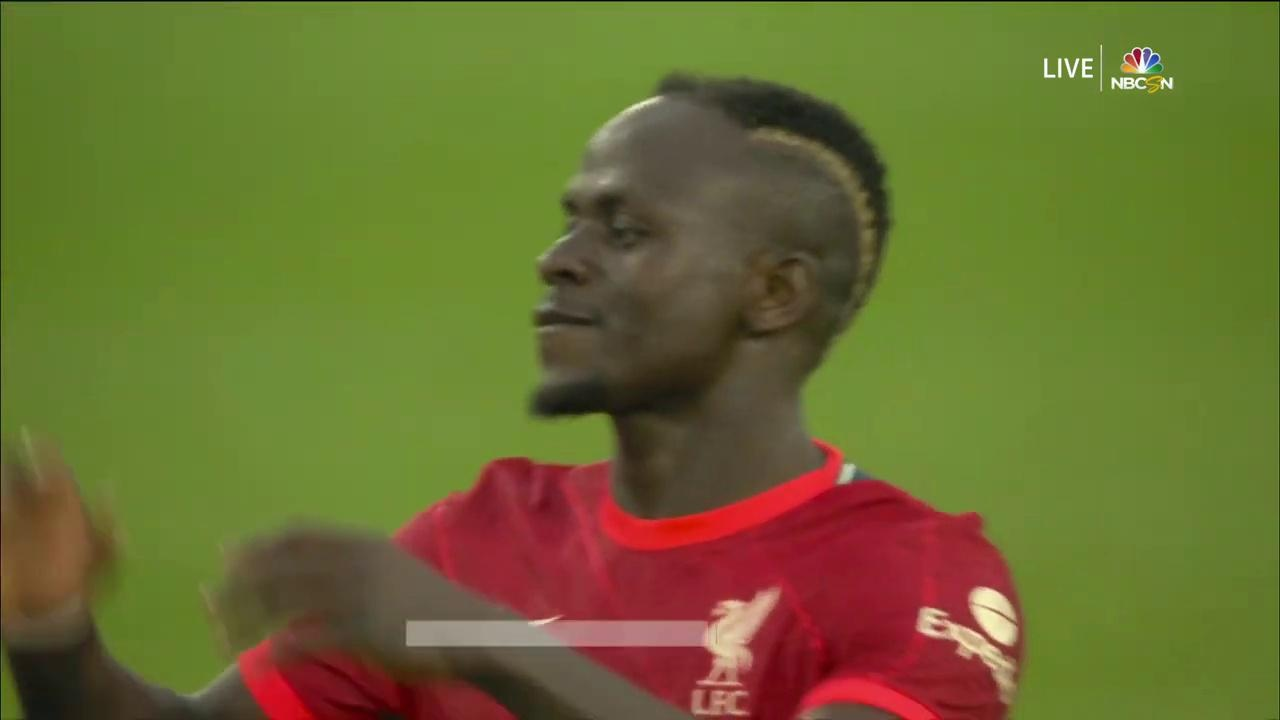

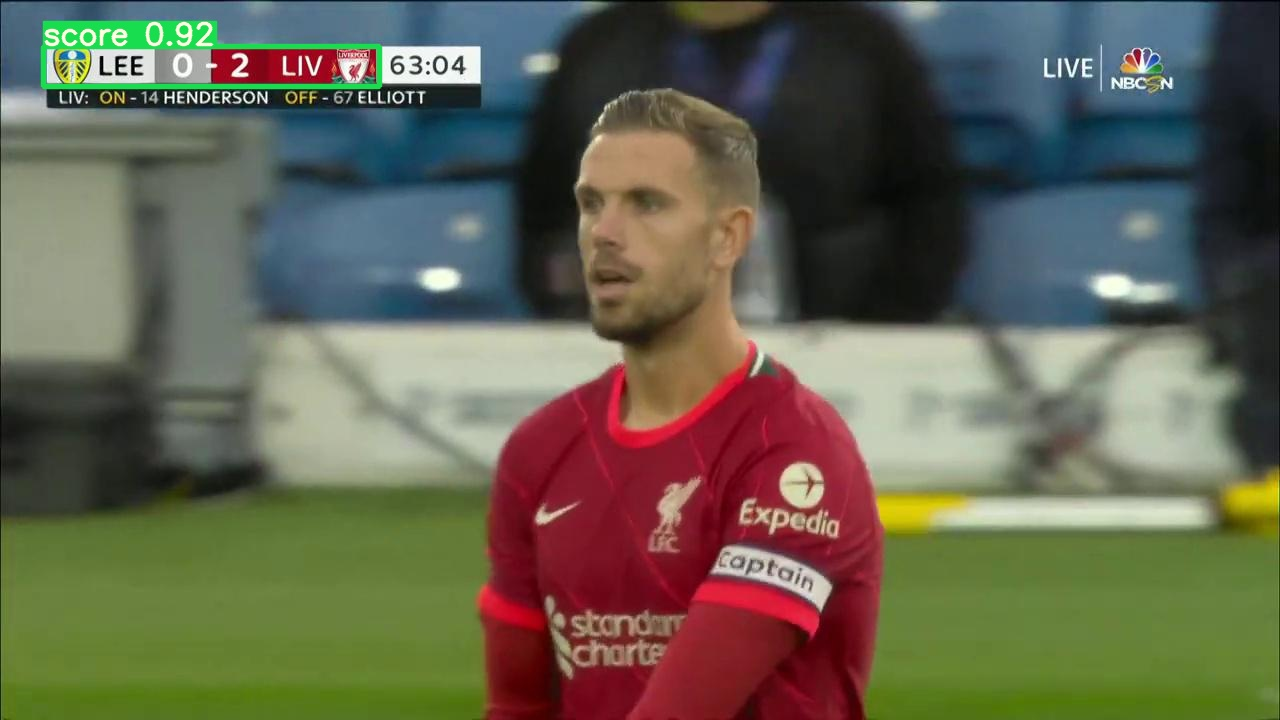

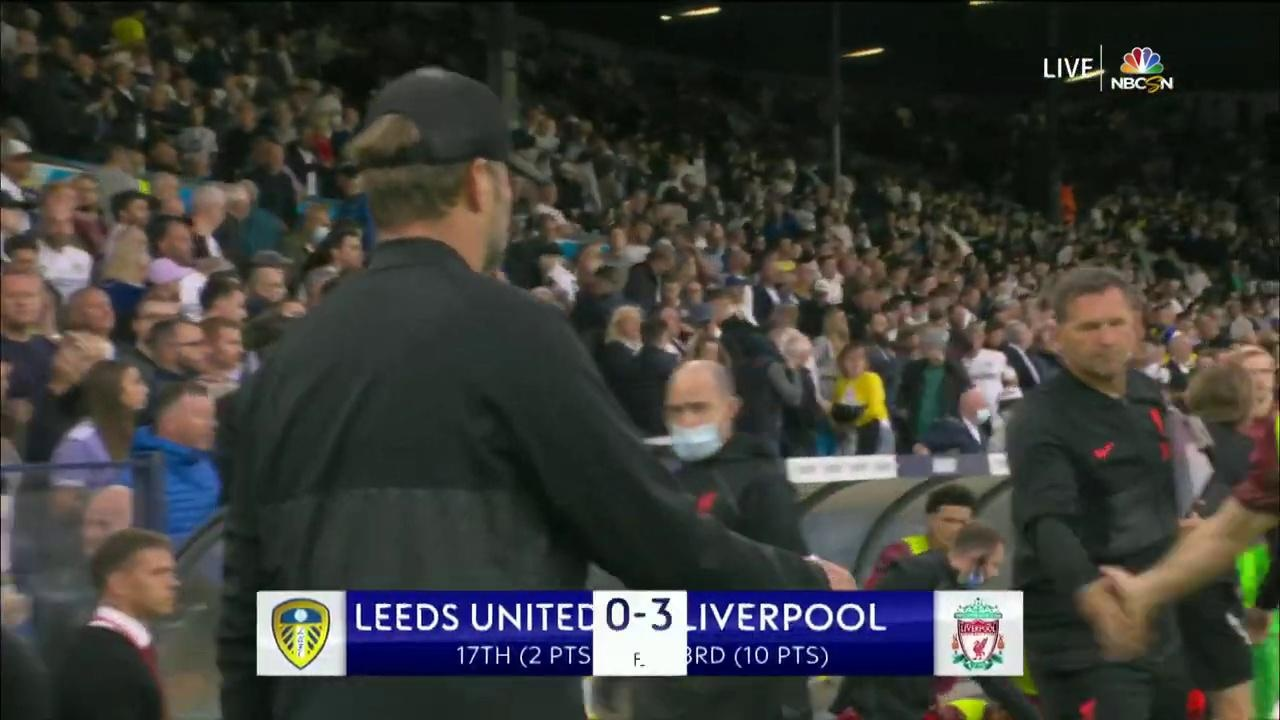

In [ ]:
import glob
from IPython.display import Image, display
for imageName in glob.glob('./runs/detect/results3/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

## Save the weight to your local drive

In [ ]:
%cp ./runs/train/yolov5_4/weights/best.pt /mydrive/yolov5/best4.pt

### Save the results in your local drive

In [ ]:
%cp -r ./runs/detect/results3/ /mydrive/yolov5

## Test the detection model on a video 

In [ ]:
%cp /mydrive/yolov5/test1.mp4 ./test/

In [ ]:
!python detect.py --weights ./runs/train/yolov5_4/weights/best.pt --img 416 --conf 0.4 --source ./test/test1.mp4 --save-txt --name 'results4'


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='results4', project='runs/detect', save_conf=False, save_txt=True, source='./test/test1.mp4', update=False, view_img=False, weights=['./runs/train/yolov5_4/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS
video 1/1 (1/3898) /content/yolov5/test/test1.mp4: 256x416 1 score, Done. (0.011s)
video 1/1 (2/3898) /cont

### Save the video with the boxes in your drive

In [ ]:
%cp -r ./runs/detect/results4/ /mydrive/yolov5/